# TBSOC Interactive Tutorial: GaAs

**Welcome to the TBSOC (Tight-Binding + SOC) Tutorial.**

In this notebook, we will demonstrate how to:
1.  Load a Wannier90 Tight-Binding model (without SOC).
2.  Load DFT reference bands (VASP typically).
3.  Use **JAX** and **Automatic Differentiation** to fit the On-site SOC parameters ($\lambda$) to match the DFT bands.
4.  Visualize the results.

In [19]:
import os
%matplotlib inline
import numpy as np
import jax
import matplotlib.pyplot as plt
from tbsoc.lib.json_loader import j_loader
from tbsoc.entrypoints.loadall import load_all_data
from tbsoc.entrypoints.fitsoc import fitsoc, find_best_alignment, build_soc_basis_matrices
from tbsoc.lib.cal_tools import hr2hk
from tbsoc.lib.jax_core import loss_fn_jax, get_Hsoc_jax

print("JAX devices:", jax.devices())

JAX devices: [CpuDevice(id=0)]


## 1. Setup and Data Loading

We start by loading the configuration from `input.json`. This file defines:
- Input file paths (`wannier90_hr.dat`, `EIGENVAL`...)
- Orbital definitions (Ga: $s, p$; As: $s, p$)
- Initial guesses for $\lambda$ (SOC strength).

In [20]:
# Ensure we are in the example directory if running interactively
# os.chdir('example/GaAs') # Uncomment if running from repo root

INPUT_FILE = "input.json"
jdata = j_loader(INPUT_FILE)

# Load all data into a dictionary
data_dict = load_all_data(**jdata)

print("Loaded Keys:", data_dict.keys())
print("Orbitals:", data_dict['orbitals'])

reading POSCAR ...
successfully reading POSCAR ...
reading wannier90.win ...
successfully reading wannier90.win ...
The projections is :
Ga 	s 	p 	
As 	s 	p 	
generating Hsoc mat for porbital in atomic orbital basis
   0.00    0.00    0.00   -1.00    0.00    1.00I

   0.00    0.00    1.00    0.00    1.00I   0.00 

   0.00    1.00    0.00    0.00   -1.00I   0.00 

  -1.00    0.00    0.00   -0.00    0.00    1.00I

   0.00   -1.00I   1.00I   0.00    0.00    0.00 

  -1.00I   0.00    0.00   -1.00I   0.00   -0.00 

transfer the spin basis form up down up down ... to up up ... down down...
generating Hsoc mat for sorbital in atomic orbital basis
   0.00    0.00 

   0.00    0.00 

transfer the spin basis form up down up down ... to up up ... down down...
reading wannier90_hr.dat ...
successfully reading wannier90_hr.dat ...
The orbital type is:  [0, 1, 2, 3]
The length of lambdas should be 4
reading KPOINTS ...
G : [   0.000,   0.000,   0.000] ===>  X : [   0.500,   0.000,   0.500]
X : [   0

## 2. Pre-calculation

The fitting process involves calculating the Hamiltonian $H(k)$ many times. 
The non-SOC part, $H_{TB}(k)$, is constant. We pre-calculate it here using vectorized operations.

In [21]:
print("Calculating Non-SOC Hk...")
hk_tb = hr2hk(
    data_dict['hop_spinor'], 
    data_dict['Rlatt'], 
    data_dict['kpath'], 
    data_dict['num_wan']
)
print("Hk shape:", hk_tb.shape)

Calculating Non-SOC Hk...
Hk shape: (240, 16, 16)


## 3. Automatic Band Alignment

A major challenge in TB fitting is that the TB model usually describes only a subset of the full DFT bands (e.g., bands 10-25).

We use an automated alignment step to find which DFT bands correspond to our TB model.

In [22]:
# Get Initial Guess parameters
orb_labels = data_dict['orb_labels']
lambda_dict = jdata.get('lambdas', {})

# Map orbital labels to lambda values from input.json
initial_all_lambdas = []
for label in orb_labels:
    # Check exact match first, then partial (e.g. 'Ga:s' matches 's' if defined generic)
    val = lambda_dict.get(label, 0.0)
    # Special case: s-orbitals usually 0 SOC
    if ':s' in label or label.strip() == 's':
        val = 0.0
    initial_all_lambdas.append(val)

initial_all_lambdas = np.array(initial_all_lambdas)
print("Initial Lambdas:", initial_all_lambdas)

fit_indices = np.where(initial_all_lambdas != 0)[0]
initial_params = initial_all_lambdas[fit_indices]

# Build Basis Matrices for JAX
soc_basis = build_soc_basis_matrices(
    initial_all_lambdas, fit_indices, 
    data_dict['orbitals'], data_dict['orb_type'], 
    data_dict['orb_num'], data_dict['Msoc']
)

# Calculate initial bands (snapshot)
hk_tb_jax = jax.numpy.array(hk_tb)
soc_basis_jax = jax.numpy.array(soc_basis)
h_soc_init = get_Hsoc_jax(initial_params, soc_basis_jax)
eigvals_init = np.array(jax.numpy.linalg.eigvalsh(hk_tb_jax + h_soc_init))

# Perform Alignment
vasp_bands = data_dict['vasp_bands']
n_wan = data_dict['num_wan']
best_offset, min_mse = find_best_alignment(
    eigvals_init, vasp_bands, 
    n_wan, vasp_bands.shape[1], vasp_bands.shape[0]
)

print(f"\nAlignment Result:\nTB bands matched to DFT bands {best_offset} - {best_offset + n_wan - 1}")
target_bands = vasp_bands[:, best_offset : best_offset + n_wan]

Initial Lambdas: [0.   0.1  0.   0.24]
Scanning offsets 0 to 22 using top 8 bands for judgement...

Alignment Result:
TB bands matched to DFT bands 10 - 25


## 4. JAX Optimization

Now we run the fitting. We use **Fermi Weighting** to prioritize the bands near the Fermi level ($E_F$).

The loss function is:
$$ Loss = \sum_{k,n} e^{-|E_{DFT} - E_F|/\sigma} (E_{TB} - E_{DFT} - \text{shift})^2 $$

In [23]:
# Run the full fitting routines
# This wrapper function does everything we did above automaticall
res = fitsoc(INPUT_FILE, outdir='./')

print("Final optimized parameters:", res['lambdas_dict'])

--- Starting JAX-accelerated SOC fitting ---
reading POSCAR ...
successfully reading POSCAR ...
reading wannier90.win ...
successfully reading wannier90.win ...
The projections is :
Ga 	s 	p 	
As 	s 	p 	
generating Hsoc mat for porbital in atomic orbital basis
   0.00    0.00    0.00   -1.00    0.00    1.00I

   0.00    0.00    1.00    0.00    1.00I   0.00 

   0.00    1.00    0.00    0.00   -1.00I   0.00 

  -1.00    0.00    0.00   -0.00    0.00    1.00I

   0.00   -1.00I   1.00I   0.00    0.00    0.00 

  -1.00I   0.00    0.00   -1.00I   0.00   -0.00 

transfer the spin basis form up down up down ... to up up ... down down...
generating Hsoc mat for sorbital in atomic orbital basis
   0.00    0.00 

   0.00    0.00 

transfer the spin basis form up down up down ... to up up ... down down...
reading wannier90_hr.dat ...
successfully reading wannier90_hr.dat ...
The orbital type is:  [0, 1, 2, 3]
The length of lambdas should be 4
reading KPOINTS ...
G : [   0.000,   0.000,   0.000] ===

In [24]:
res

{'success': True,
 'message': 'CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL',
 'mse': 0.0021407307681299494,
 'optimized_lambdas': [0.0, 0.1162587850778047, 0.0, 0.2197384863711836],
 'lambdas_dict': {'Ga:s': 0.0,
  'Ga:p': 0.1162587850778047,
  'As:s': 0.0,
  'As:p': 0.2197384863711836}}

## 5. Visualization

Let's plot the final results to visually verify the fit.

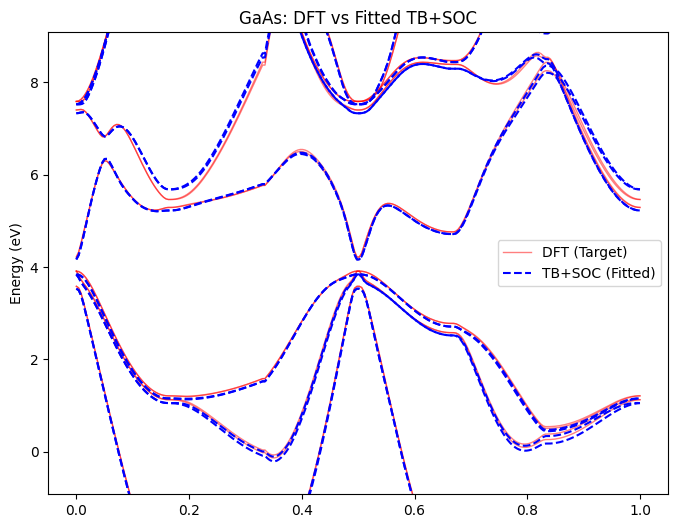

In [28]:
from tbsoc.entrypoints.addsoc import addsoc
from tbsoc.lib.plot_tools import band_plot

# Update the input data with optimized lambdas for plotting
# `res` is a dictionary containing the results

# Get optimized lambdas from result dict
final_lambdas = np.array(res['optimized_lambdas'])

# Extract the fitted parameters (the ones corresponding to fit_indices)
# soc_basis_jax was built expecting only the fitted parameters
final_params = final_lambdas[fit_indices]

# Re-calculate final bands using JAX
h_soc_final = get_Hsoc_jax(final_params, soc_basis_jax)
eigvals_final = np.array(jax.numpy.linalg.eigvalsh(hk_tb_jax + h_soc_final))

# Align for Plotting
mean_diff = np.mean(eigvals_final - target_bands)
eigvals_final_shifted = eigvals_final - mean_diff

# Plot
kpath_flat = np.linspace(0, 1, eigvals_final.shape[0])
plt.figure(figsize=(8, 6))
plt.plot(kpath_flat, target_bands, 'r-', lw=1, alpha=0.5)
plt.plot(kpath_flat, target_bands[:,0], 'r-', lw=1, alpha=0.5,label='DFT (Target)')
plt.plot(kpath_flat, eigvals_final_shifted, 'b--', lw=1.5)
plt.plot(kpath_flat, eigvals_final_shifted[:,0], 'b--', lw=1.5, label='TB+SOC (Fitted)')

plt.legend()
plt.ylabel('Energy (eV)')
plt.title('GaAs: DFT vs Fitted TB+SOC')
plt.ylim(jdata['Efermi']-5, jdata['Efermi']+5)
plt.show()